# $\delta$-Gradient Clipping on Kolmogorov-Arnold Networks (KANs)

### $\delta$-Gradient Clipping Optimizer

In [ ]:
from typing import Any, Dict, Iterable

import torch


class dGClip(torch.optim.Optimizer):
    """delta-Gradient Clipping optimizer"""

    def __init__(
        self,
        params: Iterable[torch.Tensor] | Iterable[Dict[str, Any]],
        lr: float,
        gamma: float = 0.1,
        delta: float = 0.001,
        weight_decay: float = 0,
    ) -> None:
        if lr <= 0:
            raise ValueError("Learning rate (eta) is not > 0.")
        if gamma <= 0:
            raise ValueError("Gradient norm threshold (gamma) is not > 0.")
        if delta < 0:
            raise ValueError("delta is not >= 0.")
        if weight_decay < 0:
            raise ValueError("Weight decay is not >= 0.")
        defaults = dict(lr=lr, gamma=gamma, delta=delta, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None) -> None:
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for param_group in self.param_groups:
            parameter_list = param_group["params"]
            concatenated_weights = torch.cat(
                [param.grad.view(-1) for param in parameter_list]
            )
            gradient_norm = torch.norm(concatenated_weights)

            if gradient_norm != 0:
                step_size = param_group["lr"] * min(
                    1, max(param_group["delta"], param_group["gamma"] / gradient_norm)
                )
            else:
                step_size = 0

            for p in param_group["params"]:
                if param_group["weight_decay"]:
                    p.grad = p.grad.add(p, alpha=param_group["weight_decay"])
                p.add_(p.grad, alpha=-step_size)

        return loss

### Defining the KAN

The implementation of this experiment and the KAN was taken from: https://github.com/Blealtan/efficient-kan/tree/master

In [ ]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

## Experiment

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

torch.manual_seed(1000)
np.random.seed(1000)

def main(experiment):

    # Load MNIST
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    trainset = torchvision.datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )
    valset = torchvision.datasets.MNIST(
        root="./data", train=False, download=True, transform=transform
    )
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = DataLoader(valset, batch_size=64, shuffle=False)

    # Define model
    model = KAN([28 * 28, 64, 10])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define optimizer
    algo = experiment.settings_get("algo")
    eta = experiment.settings_get("eta")
    gamma = experiment.settings_get("gamma")
    delta = experiment.settings_get("delta")
    if algo == "adamw":
        optimizer = optim.AdamW(model.parameters(), lr=eta, weight_decay=1e-4)
    elif algo == "adam":
        optimizer = optim.Adam(model.parameters(), lr=eta, weight_decay=1e-4)
    elif algo == "dgclip":
        optimizer = dGClip(model.parameters(), eta, gamma, delta, weight_decay=1e-4)
    elif algo == "gclip":
        optimizer = dGClip(model.parameters(), eta, gamma, delta=0, weight_decay=1e-4)
    elif algo == "gd":
        optimizer = optim.SGD(model.parameters(), eta, weight_decay=1e-4)
    else:
        raise ValueError("Invalid optimizer name:", algo)

    # Only use scheduler for adamw, adam and (s)gd.
    if not (algo == "dgclip" or algo == "gclip"):
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

    # Define loss
    criterion = nn.CrossEntropyLoss()

    training_losses, training_accuracies = [], []
    validation_losses, validation_accuracies = [], []
    epochs = experiment.settings_get("epochs")
    for epoch in range(epochs):

        # Train
        model.train()
        train_loss = 0
        train_accuracy = 0
        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
                train_loss += loss.item()
                train_accuracy += accuracy.item()
        train_loss /= len(trainloader)
        train_accuracy /= len(trainloader)
        training_losses.append(train_loss)
        training_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(-1, 28 * 28).to(device)
                output = model(images)
                val_loss += criterion(output, labels.to(device)).item()
                val_accuracy += (
                    (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                )
        val_loss /= len(valloader)
        val_accuracy /= len(valloader)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_accuracy)

        # Update learning rate
        if not (algo == "dgclip" or algo == "gclip"):
            scheduler.step()

        # print(f"Epoch {epoch + 1}", end=" ")
        # print(f"{val_loss=} {val_accuracy=} {train_loss=} {train_accuracy=}")

    experiment.add_results(
        validation_losses, validation_accuracies, training_losses, training_accuracies
    )

In [ ]:
class Experiment:
    def __init__(self, algo, eta, gamma=None, delta=None, seed=None, epochs=10) -> None:
        self.initial_settings = dict()
        self.initial_settings["algo"] = algo.lower()
        self.initial_settings["eta"] = eta
        self.initial_settings["gamma"] = gamma
        self.initial_settings["delta"] = delta
        self.initial_settings["seed"] = seed
        self.initial_settings["epochs"] = epochs
        self.results = []

    def get_pretty_name(self):
        algo = self.settings_get("algo")
        if algo == "dgclip":
            return f"$\delta$-GClip ($\eta$={self.settings_get('eta')};$\gamma$={self.settings_get('gamma')};$\delta$={self.settings_get('delta')})"
        elif algo == "gclip":
            return f"GClip ($\eta$={self.settings_get('eta')};$\gamma$={self.settings_get('gamma')})"
        elif algo == "adamw":
            return f"AdamW ({self.settings_get('eta')})"
        elif algo == "adam":
            return f"Adam ({self.settings_get('eta')})"
        elif algo == "gd" or algo == "sgd":
            return f"SGD ({self.settings_get('eta')})"
        else:
            raise ValueError(f"Un-printable algorithm type: {self.algo}")

    def set_seed(self, seed):
        self.initial_settings["seed"] = seed

    def get_seed(self):
        return self.initial_settings["seed"]

    def add_results(self, val_loss, val_acc, train_loss, train_acc):
        assert len(val_loss) == len(val_acc)
        assert len(val_acc) == len(train_loss)
        assert len(train_loss) == len(train_acc)
        assert len(train_acc) == self.settings_get("epochs")
        self.results.append(
            {
                "seed": self.get_seed(),
                "validation_loss": val_loss,
                "validation_accuracy": val_acc,
                "training_loss": train_loss,
                "training_accuracy": train_acc
            }
        )

    def get_experiment_runs(self):
        val_losses = [r["validation_loss"] for r in self.results]
        val_accs = [r["validation_accuracy"] for r in self.results]
        train_losses = [r["training_loss"] for r in self.results]
        train_accs = [r["training_accuracy"] for r in self.results]
        return val_losses, val_accs, train_losses, train_accs

    def settings_get(self, key):
        return self.initial_settings.get(key)

    def __str__(self):
        str_repr = "Initial settings: " + str(self.initial_settings)
        str_repr += "\nResults: " + str(self.results)
        return str_repr


In [ ]:
seeds = [100, 200, 300, 400, 500]

epochs = 10

experiments = [
    Experiment(algo="adamw", eta=0.001, epochs=epochs),
    Experiment(algo="adam", eta=0.001, epochs=epochs),
    Experiment(algo="dgclip", eta=1, gamma=0.5, delta=0.5, epochs=epochs),
    Experiment(algo="gclip", eta=1, gamma=0.5, delta=0, epochs=epochs),
    Experiment(algo="gd", eta=0.1, epochs=epochs),
]

results = []

for seed in seeds:
    for exp in experiments:
        exp.set_seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        print(f"Starting experiment: {exp.get_pretty_name()} with seed {exp.get_seed()}.")
        main(exp)
        print()

Starting experiment: AdamW (0.001) with seed 100.
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5114877.79it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134352.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1271623.34it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5671488.17it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 938/938 [00:18<00:00, 51.78it/s, accuracy=0.969, loss=0.143, lr=0.000134]



Starting experiment: Adam (0.001) with seed 100.


100%|██████████| 938/938 [00:17<00:00, 53.12it/s, accuracy=0.969, loss=0.236, lr=0.000134]



Starting experiment: $\delta$-GClip ($\eta$=1;$\gamma$=0.5;$\delta$=0.5) with seed 100.


100%|██████████| 938/938 [00:18<00:00, 51.50it/s, accuracy=0.938, loss=0.241, lr=1]



Starting experiment: GClip ($\eta$=1;$\gamma$=0.5) with seed 100.


100%|██████████| 938/938 [00:18<00:00, 51.86it/s, accuracy=0.938, loss=0.357, lr=1]



Starting experiment: SGD (0.1) with seed 100.


100%|██████████| 938/938 [00:18<00:00, 51.57it/s, accuracy=0.906, loss=0.362, lr=0.0134]



Starting experiment: AdamW (0.001) with seed 200.


100%|██████████| 938/938 [00:17<00:00, 52.41it/s, accuracy=1, loss=0.022, lr=0.000134]



Starting experiment: Adam (0.001) with seed 200.


100%|██████████| 938/938 [00:18<00:00, 51.36it/s, accuracy=0.969, loss=0.0647, lr=0.000134]



Starting experiment: $\delta$-GClip ($\eta$=1;$\gamma$=0.5;$\delta$=0.5) with seed 200.


100%|██████████| 938/938 [00:18<00:00, 52.00it/s, accuracy=1, loss=0.024, lr=1]



Starting experiment: GClip ($\eta$=1;$\gamma$=0.5) with seed 200.


100%|██████████| 938/938 [00:17<00:00, 52.83it/s, accuracy=1, loss=0.0287, lr=1]



Starting experiment: SGD (0.1) with seed 200.


100%|██████████| 938/938 [00:17<00:00, 53.90it/s, accuracy=0.969, loss=0.112, lr=0.0134]



Starting experiment: AdamW (0.001) with seed 300.


100%|██████████| 938/938 [00:17<00:00, 52.54it/s, accuracy=1, loss=0.0145, lr=0.000134]



Starting experiment: Adam (0.001) with seed 300.


100%|██████████| 938/938 [00:17<00:00, 52.51it/s, accuracy=1, loss=0.0269, lr=0.000134]



Starting experiment: $\delta$-GClip ($\eta$=1;$\gamma$=0.5;$\delta$=0.5) with seed 300.


100%|██████████| 938/938 [00:17<00:00, 52.47it/s, accuracy=1, loss=0.00715, lr=1]



Starting experiment: GClip ($\eta$=1;$\gamma$=0.5) with seed 300.


100%|██████████| 938/938 [00:17<00:00, 52.82it/s, accuracy=1, loss=0.0133, lr=1]



Starting experiment: SGD (0.1) with seed 300.


100%|██████████| 938/938 [00:17<00:00, 53.40it/s, accuracy=0.938, loss=0.135, lr=0.0134]



Starting experiment: AdamW (0.001) with seed 400.


100%|██████████| 938/938 [00:17<00:00, 52.59it/s, accuracy=1, loss=0.0204, lr=0.000134]



Starting experiment: Adam (0.001) with seed 400.


100%|██████████| 938/938 [00:17<00:00, 53.34it/s, accuracy=1, loss=0.0291, lr=0.000134]



Starting experiment: $\delta$-GClip ($\eta$=1;$\gamma$=0.5;$\delta$=0.5) with seed 400.


100%|██████████| 938/938 [00:17<00:00, 53.40it/s, accuracy=1, loss=0.0174, lr=1]



Starting experiment: GClip ($\eta$=1;$\gamma$=0.5) with seed 400.


100%|██████████| 938/938 [00:17<00:00, 53.46it/s, accuracy=1, loss=0.0155, lr=1]



Starting experiment: SGD (0.1) with seed 400.


100%|██████████| 938/938 [00:17<00:00, 53.71it/s, accuracy=1, loss=0.0805, lr=0.0134]



Starting experiment: AdamW (0.001) with seed 500.


100%|██████████| 938/938 [00:17<00:00, 52.56it/s, accuracy=0.969, loss=0.0612, lr=0.000134]



Starting experiment: Adam (0.001) with seed 500.


100%|██████████| 938/938 [00:18<00:00, 50.80it/s, accuracy=0.969, loss=0.119, lr=0.000134]



Starting experiment: $\delta$-GClip ($\eta$=1;$\gamma$=0.5;$\delta$=0.5) with seed 500.


100%|██████████| 938/938 [00:17<00:00, 53.15it/s, accuracy=0.969, loss=0.0615, lr=1]



Starting experiment: GClip ($\eta$=1;$\gamma$=0.5) with seed 500.


100%|██████████| 938/938 [00:17<00:00, 53.44it/s, accuracy=0.969, loss=0.0901, lr=1]



Starting experiment: SGD (0.1) with seed 500.


100%|██████████| 938/938 [00:17<00:00, 53.80it/s, accuracy=0.969, loss=0.214, lr=0.0134]


### Display Results

In [ ]:
import matplotlib.pyplot as plt

def plot_shaded_errors(ax, values, labels, ylabel):
    epochs = range(1, len(values[0][0]) + 1)
    for (mean, std), label in zip(values, labels):
        ax.plot(epochs, mean, label=label)
        ax.fill_between(epochs, [m-s for m,s in zip(mean,std)], [m+s for m,s in zip(mean,std)], alpha=0.3)
    ax.set_xlabel("Epochs", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)


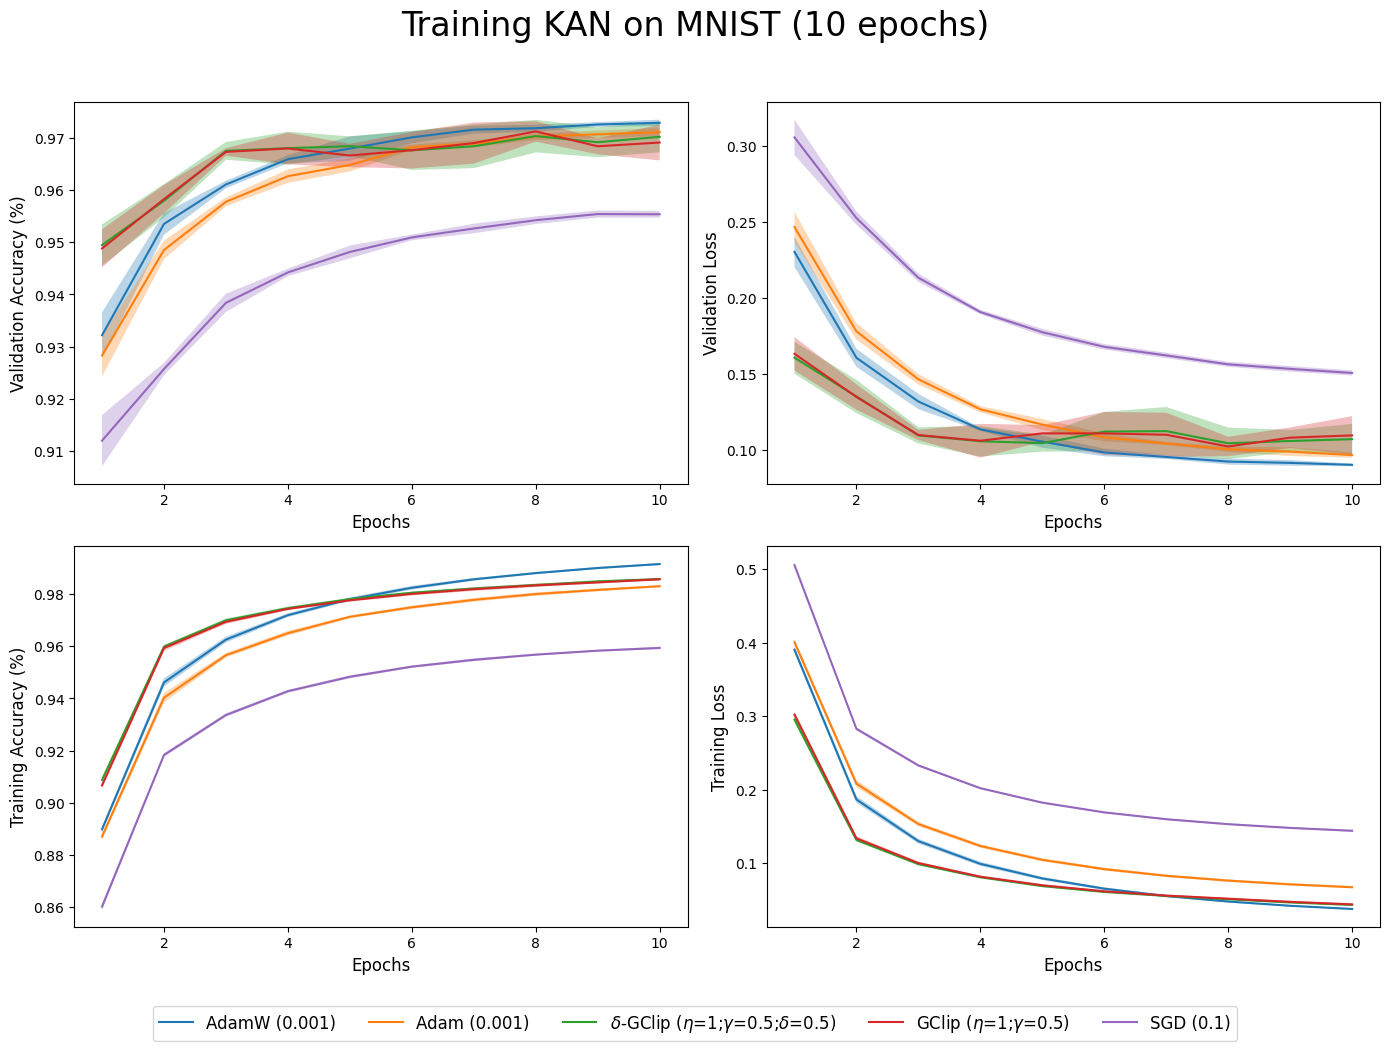

In [ ]:
validation_accuracy_values = []
validation_loss_values = []
training_accuracy_values = []
training_loss_values = []
labels = [e.get_pretty_name() for e in experiments]

for exp in experiments:
    val_losses, val_accs, train_losses, train_accs = exp.get_experiment_runs()
    validation_accuracy_values.append((np.mean(val_accs, axis=0), np.std(val_accs, axis=0)))
    validation_loss_values.append((np.mean(val_losses, axis=0), np.std(val_losses, axis=0)))
    training_accuracy_values.append((np.mean(train_accs, axis=0), np.std(train_accs, axis=0)))
    training_loss_values.append((np.mean(train_losses, axis=0), np.std(train_losses, axis=0)))


fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Training KAN on MNIST (10 epochs)", fontsize=24)
plot_shaded_errors(axs[0, 0], validation_accuracy_values, labels, "Validation Accuracy (%)")
plot_shaded_errors(axs[0, 1], validation_loss_values, labels, "Validation Loss")
plot_shaded_errors(axs[1, 0], training_accuracy_values, labels, "Training Accuracy (%)")
plot_shaded_errors(axs[1, 1], training_loss_values, labels, "Training Loss")
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels), bbox_to_anchor=(0.5, -0.06), fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()